In [1]:
# prepare a table for principle component analysis and execute

import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

database = duckdb.connect(r'C:\Users\davee\Desktop\SP\pca_development\duck_db_analysis_database.db', read_only=False) 
print("connected")



connected


In [2]:
analysis_id = 213

# select an id and 
# 1) read all data from results-table for this id
result_table = database.execute(f'select * from results where analysis_id == {analysis_id}').fetchdf()
print(result_table)
print(np.unique(result_table["analysis_function_id"]))


     analysis_id  analysis_function_id               sweep_table_name  \
0            213                   214  imon_signal_220810_10_Series3   
1            213                   214  imon_signal_220810_11_Series2   
2            213                   214  imon_signal_220810_12_Series4   
3            213                   214  imon_signal_220810_13_Series3   
4            213                   214  imon_signal_220810_14_Series3   
..           ...                   ...                            ...   
804          213                   239  imon_signal_220804_07_Series3   
805          213                   239  imon_signal_220804_08_Series5   
806          213                   239  imon_signal_220804_09_Series4   
807          213                   239  imon_signal_220804_10_Series4   
808          213                   239  imon_signal_220317_03_Series3   

                            specific_result_table_name  
0    results_analysis_function_214_imon_signal_2208...  
1    resu

In [3]:
# 2) read expeirment_names related with this id
experiment_names = database.execute(f'select experiment_name from experiment_analysis_mapping where analysis_id =={analysis_id}').fetchdf()
print(experiment_names)

    experiment_name
0         220810_10
1         220810_11
2         220810_12
3         220810_13
4         220810_14
..              ...
108       220804_06
109       220804_07
110       220804_08
111       220804_09
112       220804_10

[113 rows x 1 columns]


In [4]:
result_table[result_table["analysis_function_id"]==214]["specific_result_table_name"]

0      results_analysis_function_214_imon_signal_2208...
1      results_analysis_function_214_imon_signal_2208...
2      results_analysis_function_214_imon_signal_2208...
3      results_analysis_function_214_imon_signal_2208...
4      results_analysis_function_214_imon_signal_2208...
                             ...                        
102    results_analysis_function_214_imon_signal_2208...
103    results_analysis_function_214_imon_signal_2208...
104    results_analysis_function_214_imon_signal_2208...
105    results_analysis_function_214_imon_signal_2203...
106    results_analysis_function_214_imon_signal_2203...
Name: specific_result_table_name, Length: 107, dtype: object

In [5]:
# step 1: built the header 
#-> for all recordings where differences between sweeps are expected -> add each single sweep
#-> if no differences are expected (e.g. 5x same action potential) add the mean value  
#          for IV, IV-40, Inact,CClamp,Rheoramp analysis_id::sweep_Number
#          for action potential fitting: mean of all sweeps
#          for rheobase
pca_result_data_frame = pd.DataFrame()

for analysis_function_id in np.unique(result_table["analysis_function_id"]):
    analysis_series_name = database.execute(f'select analysis_series_name from analysis_functions where analysis_function_id == {analysis_function_id}').fetchdf().values.tolist()[0][0]
    
    print(analysis_series_name)
    sweep_table_names = result_table[result_table["analysis_function_id"]==analysis_function_id]["sweep_table_name"].values.tolist()
    res_table_names = result_table[result_table["analysis_function_id"]==analysis_function_id]["specific_result_table_name"].values.tolist()    
    data_list = []
    header = []
    for table_name in res_table_names:
        index = res_table_names.index(table_name)
        experiment_name = database.execute(f'select experiment_name from experiment_series where sweep_table_name == \'{sweep_table_names[index]}\'').fetchdf().values.tolist()[0][0]
        res_data = database.execute(f'select * from {table_name}').fetchdf()
        
        if analysis_series_name in ['IV']: #, 'IV-40'
            if not header:
                #print(res_data)
                print(res_data)
                header.append("experiment_name")
                for sweep in res_data["Sweep_Number"].values.tolist():
                    print(sweep)
                    header.append(str(analysis_function_id)+"::"+"sweep_"+str(sweep)) 
            else:
                data = [experiment_name]+res_data["Result"].values.tolist()
                if len(data)!=len(header):
                    print("ERROR lenght data ", len(data), "as unqueal to len of header ", len(header))
                    print(experiment_name)
                    print(table_name)
                    print(res_data)
                    print(header)
                    print(data)
                    
                else:
                    data_list.append(data)
            
        if analysis_series_name in ['5xRheo']:
            if not header:
                header.append("experiment_name")
                for param in res_data["Fitting Parameters"].values.tolist():
                    header.append(str(analysis_function_id)+"::"+param)
            
            data_row = []            
            data_row.append(experiment_name)
            for row in range(0,len(res_data["Fitting Parameters"].values.tolist())):
                # last item is the name of the identifier
                row_vals = res_data.iloc[row].values.tolist()
                #print(row_vals)
                row_vals = row_vals[0:len(row_vals)-1]
                #print(row_vals)
                data_row.append(np.mean(row_vals))
            data_list.append(data_row)
    
    df = pd.DataFrame(data_list, columns = header)
    df = df.set_index("experiment_name", drop=True)
    print(df)
    pca_result_data_frame = pd.concat([pca_result_data_frame, df], axis=1)
    #print(pca_result_data_frame)    
    

# for each performed analysis function (identified by id):

#        - get information value for each sweep or mean of all sweeps
# 


# step 2: fill the dataframe with epxeriment specific results from the related result tables

IV
    Analysis_ID  Function_Analysis_ID               Sweep_Table_Name  \
0           213                   214  imon_signal_220810_10_Series3   
1           213                   214  imon_signal_220810_10_Series3   
2           213                   214  imon_signal_220810_10_Series3   
3           213                   214  imon_signal_220810_10_Series3   
4           213                   214  imon_signal_220810_10_Series3   
5           213                   214  imon_signal_220810_10_Series3   
6           213                   214  imon_signal_220810_10_Series3   
7           213                   214  imon_signal_220810_10_Series3   
8           213                   214  imon_signal_220810_10_Series3   
9           213                   214  imon_signal_220810_10_Series3   
10          213                   214  imon_signal_220810_10_Series3   
11          213                   214  imon_signal_220810_10_Series3   
12          213                   214  imon_signal_220810_10_

                 215::sweep_1  215::sweep_2  215::sweep_3  215::sweep_4  \
experiment_name                                                           
220810_11           -0.356979     -0.292992     -0.012305     -0.104400   
220810_12           -0.434613     -0.147454      0.273335      0.800316   
220810_13           -0.396593     -0.377968     -0.220103     -0.695969   
220810_14           -0.569619     -0.081805      0.251027      0.544776   
220318_04           -1.400632     -0.837399     -0.402607      0.125461   
...                       ...           ...           ...           ...   
220804_08           -0.971607     -0.703806      0.184963      0.111294   
220804_09           -0.378148     -0.061416      0.143677      0.449777   
220804_10           -0.975064     -0.706994      0.055302      0.091103   
220317_03           -0.568864     -0.015959      0.506106      0.889652   
220316_04           -0.779199     -0.055734      0.073240     -0.290815   

                 215::sw

KeyError: "None of ['experiment_name'] are in the columns"

                 214::sweep_1  214::sweep_2  214::sweep_3  214::sweep_4  \
experiment_name                                                           
220810_11            0.420189      0.743232      1.250593      1.482319   
220810_12            0.612647      1.109257      1.582409      2.528294   
220810_13            0.682341      0.984896      1.142762      1.745829   
220810_14            0.391873      0.853701      1.524355      2.597692   
220318_04           -0.456944      0.031787      0.416911      0.994647   
...                       ...           ...           ...           ...   
220317_03            0.394933      0.903011      1.313006      2.144830   
220316_04            0.739185      1.641283      3.735224      7.837003   
220810_10                 NaN           NaN           NaN           NaN   
220317_076                NaN           NaN           NaN           NaN   
220317_04                 NaN           NaN           NaN           NaN   

                 214::sw

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 220810_11 to 220317_04
Data columns (total 60 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   214::sweep_1                      106 non-null    float64
 1   214::sweep_2                      106 non-null    float64
 2   214::sweep_3                      106 non-null    float64
 3   214::sweep_4                      106 non-null    float64
 4   214::sweep_5                      106 non-null    float64
 5   214::sweep_6                      106 non-null    float64
 6   214::sweep_7                      106 non-null    float64
 7   214::sweep_8                      106 non-null    float64
 8   214::sweep_9                      106 non-null    float64
 9   214::sweep_10                     106 non-null    float64
 10  214::sweep_11                     106 non-null    float64
 11  214::sweep_12                     106 non-null    float64
 12 

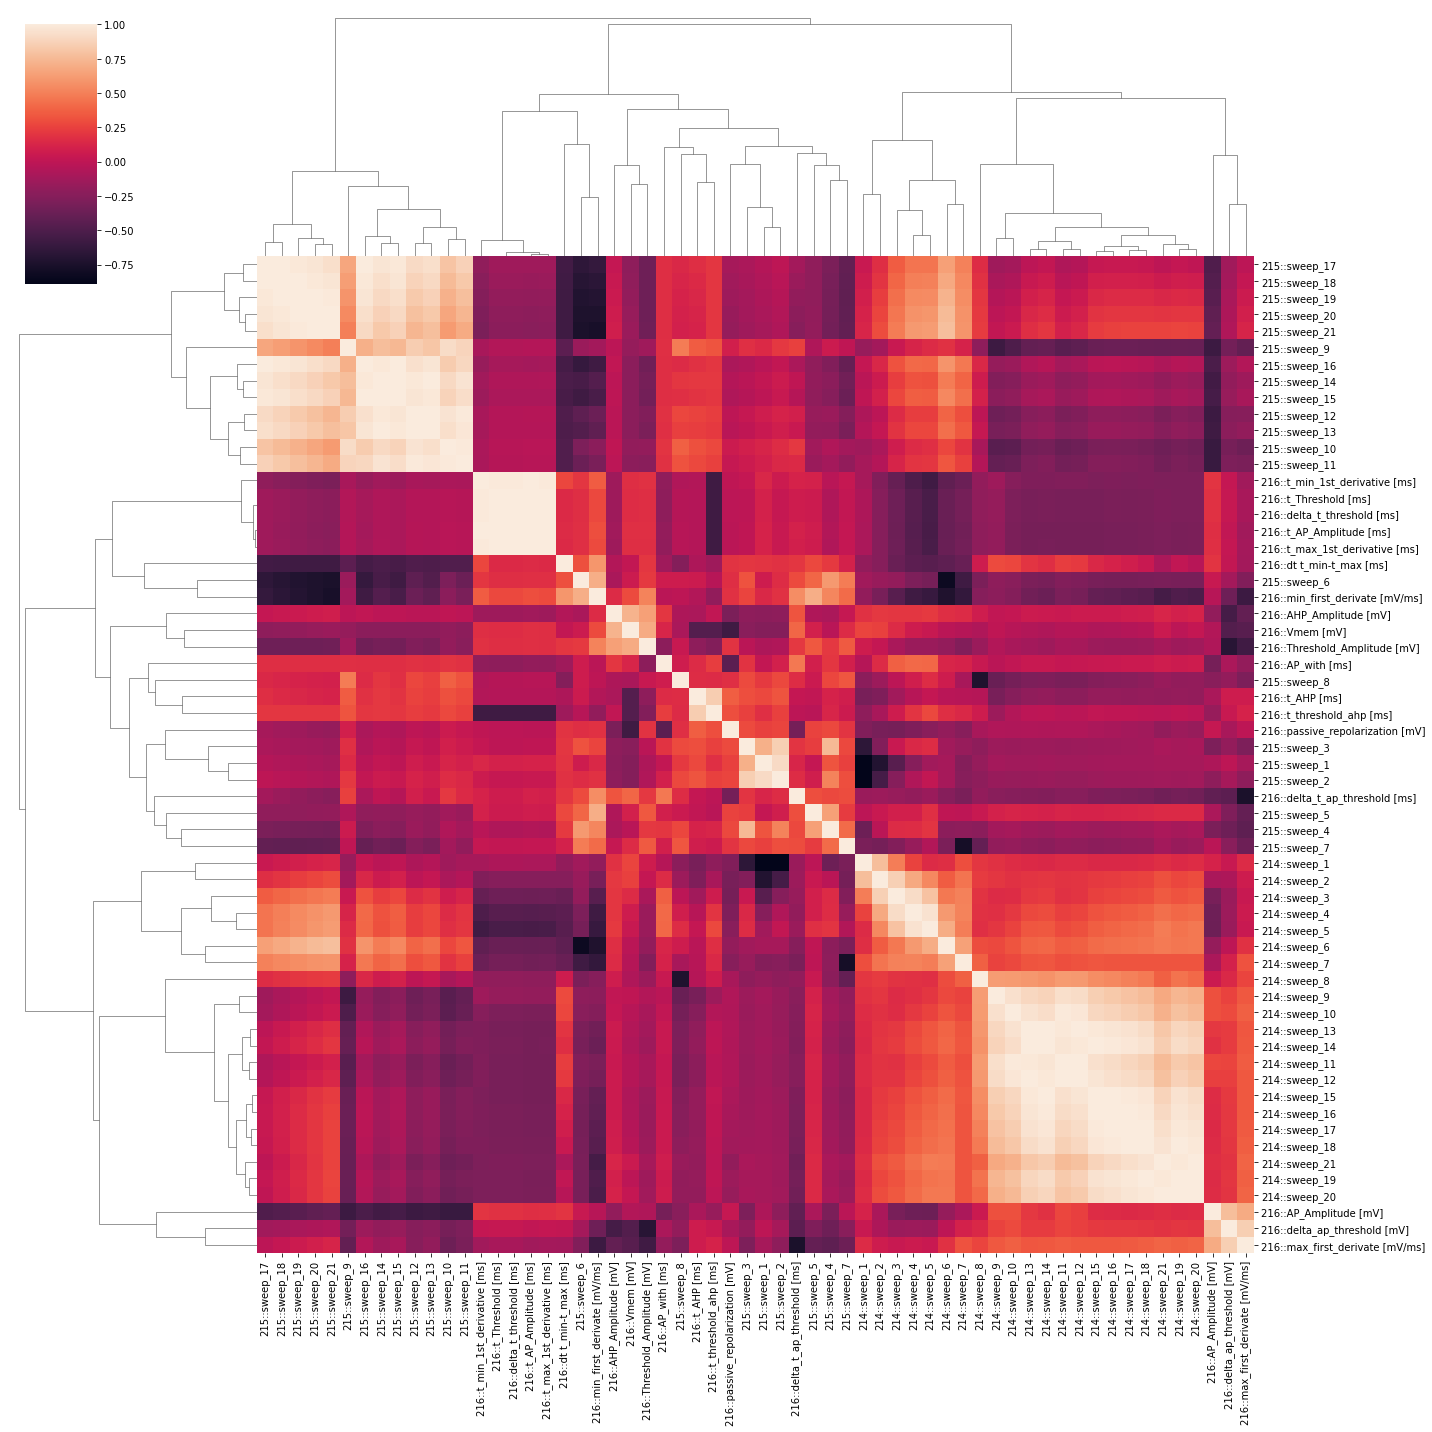

In [12]:
#pca_result_data_frame = pca_result_data_frame.set_index("experiment_name", drop=True)
print(pca_result_data_frame)
#print(pd.unique(pca_result_data_frame["experiment_name"]))
import seaborn as sns 

correlation_dataframe = pca_result_data_frame.corr()
print(correlation_dataframe.head())
sns.clustermap(data = correlation_dataframe, figsize = (20,20))
print(pca_result_data_frame.info())

In [ ]:
#! pip install sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

# df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=pca_result_data_frame.shape[1])
pca.fit(pca_result_data_frame)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T, columns=['PC%s' % _ for _ in range(len(pca_result_data_frame.columns))], index=pca_result_data_frame.columns)

print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

x_reduced = PCA(n_components=3).fit_transform(pca_result_data_frame)

plot.scatter(x_reduced[:,0], x_reduced[:,1], x_reduced[:,2])#, c = list(pca_result_data_frame.index),edgecolor="k",s=40)